In [1]:
folder = '../logs/commons_harvest_open/scenario_0'
arch = 'generative_agents'
llm_model = 'gpt4o'

In [2]:
import os

simulations_folder = os.path.join(folder, arch, llm_model)
sim_folder = os.listdir(simulations_folder)[0]
sim_folder_path = os.path.join(simulations_folder, sim_folder)
sim_log_file = os.path.join(sim_folder_path, '2024-09-20--10-31-27.log')

In [3]:
turn_start_pat = r'^################Agent\'s (\w+) turn################'
prompt_start_pat = r'^step \d+ - step_\d+ - INFO - llm.base_llm - completion:182 - Prompt:'
prompt_end_pat = r'^None - step_0 - INFO - httpx - _send_single_request:1013 - HTTP Request: POST https://api\.openai\.com/v1/chat/completions'
invalid_act_prompt_pat =r'^step \d+ - step_\d+ - WARNING - agent.cognitive_modules.act - actions_sequence:70 - Could not find action in the response_dict'
act_prompt_unique_feat_pat = r'^\s+"Consequences":\s+string+\s+[\\]+\s+.+'
response_start_pat = r'^step \d+ - step_\d+ - INFO - llm.base_llm - completion:185 - Response:'
response_end_pat = r'^step \d+ - step_\d+ - INFO - llm.base_llm - completion:188 - Prompt tokens: \d+'
game_observations_pat = r'^step \d+ - step_\d+ - INFO - __main__ - game_loop:60 - \w+ Observations: '

In [4]:
import re
import numbers

def extract_prompts(sim_log_file, type = None):
    cot_agent_prompt = type == 'cot_agent'
    # init flags
    prompt_flags = dict(
        is_prompt_start = False,
        is_act_prompt = False
    )
    response_flags = dict(
        is_response_start = False,
    )
    turn_flags = dict( # This flags are reset when the turn change
        act_response_successful = False
    )
    prompt_response_pair_flags = dict( # This flags can be set between the prompt start and response end, are reinitialized after the response end
        act_prompt_called = False
    )
    stats = dict(
        total_prompts = 0,
        total_turns = 0,
        invalid_prompts = 0,
        act_prompts = 0,
    )
    tmp_prompt_data = dict(
        prompt_content = '',
    )
    tmp_response_data = dict(
        response_content = '',
    )
    tmp_turn_data = dict( # This info is only available while the turn has not changed
        game_observations = ''
    )
    accum_data = dict(
        act_prompts_content = [],
        act_prompts_response = [],
        game_observations_for_act = []
    )
    agent = None

    def reset_flags(flags_dicts):
        for flag in flags_dicts:
            if isinstance(flags_dicts[flag], bool):
                flags_dicts[flag] = False
            elif isinstance(flags_dicts[flag], numbers.Number):
                flags_dicts[flag] = 0
            elif isinstance(flags_dicts[flag], str):
                flags_dicts[flag] = ''
            else:
                raise Exception(f'Unsupported type of flag: {type(flags_dicts[flag])}')
            
    def end_turn_hook():
        stats['total_turns'] += 1
        if tmp_turn_data['game_observations'] and turn_flags['act_response_successful']:
            accum_data['game_observations_for_act'].append(tmp_turn_data['game_observations'])

    def end_prompt_hook(prompt_flags, stats, accum_data, tmp_prompt_data, turn_flags):
        stats['total_prompts'] += 1

        # Is it was an act prompt save it
        if prompt_flags['is_act_prompt']:
            stats['act_prompts'] += 1
            accum_data['act_prompts_content'].append(tmp_prompt_data['prompt_content'])
            prompt_response_pair_flags['act_prompt_called'] = True

        reset_flags(tmp_prompt_data)
        reset_flags(prompt_flags)


    with open(sim_log_file) as file:
        for line in file:
            ###### Turns

            # Check if it is a new turn
            is_new_turn = re.match(turn_start_pat, line)
            if is_new_turn:
                agent = is_new_turn.group(1)

                end_turn_hook()

                # Reset flags
                reset_flags(turn_flags)
                reset_flags(tmp_turn_data)
                if prompt_flags['is_prompt_start']:
                    print('There was a prompt ending that was not catch')
                    reset_flags(tmp_prompt_data)
                    reset_flags(prompt_flags)
                if response_flags['is_response_start']:
                    print('There was a response ending that was not catch')
                    reset_flags(tmp_response_data)
                    reset_flags(response_flags)

            ###### Prompts
            
            # Check if a prompt starts
            prompt_start_match = re.match(prompt_start_pat, line)
            if prompt_start_match:
                prompt_flags['is_prompt_start'] = True

            # Check if a prompt ends
            prompt_end_match = re.match(prompt_end_pat, line)
            if prompt_flags['is_prompt_start'] and prompt_end_match:
                end_prompt_hook(prompt_flags, stats, accum_data, tmp_prompt_data, turn_flags)

            # Check if the prompt was invalid
            if (not prompt_flags['is_prompt_start']) and re.match(invalid_act_prompt_pat, line):
                stats['invalid_prompts'] += 1
                stats['act_prompts'] -= 1
                # Delete the last act prompt
                accum_data['act_prompts_content'] = accum_data['act_prompts_content'][:-1]
                prompt_response_pair_flags['act_prompt_called'] = False
                accum_data['act_prompts_response'] = accum_data['act_prompts_response'][:-1]
                turn_flags['act_response_successful'] = False

            # Check if it is an act prompt
            act_prompt_match = prompt_flags['is_prompt_start'] and re.match(act_prompt_unique_feat_pat, line)
            if cot_agent_prompt: # The only prompt is the act prompt
                act_prompt_match = prompt_flags['is_prompt_start']
            if act_prompt_match:
                prompt_flags['is_act_prompt'] = True

            # Save the prompt_content
            if prompt_flags['is_prompt_start']:
                tmp_prompt_data['prompt_content'] += line

            ###### Prompt Responses

            # Check if a prompt response starts
            if (not prompt_flags['is_prompt_start']) and re.match(response_start_pat, line):
                response_flags['is_response_start'] = True

            # Save the response content
            if response_flags['is_response_start']:
                tmp_response_data['response_content'] += line

            # Check if the response ends
            if response_flags['is_response_start'] and re.match(response_end_pat, line):
                response_flags['is_response_start'] = False
                if prompt_response_pair_flags['act_prompt_called']:
                    accum_data['act_prompts_response'].append(tmp_response_data['response_content'])
                    turn_flags['act_response_successful'] = True
                reset_flags(tmp_response_data)
                reset_flags(response_flags)
                reset_flags(prompt_response_pair_flags)

            ###### Game observations
            if (not prompt_flags['is_prompt_start']) and (not response_flags['is_response_start']) and re.match(game_observations_pat, line):
                tmp_turn_data['game_observations'] = line


    print('total prompts:', stats['total_prompts'], 'invalid_prompts:', stats['invalid_prompts'], 'act_prompts', stats['act_prompts'], len(accum_data['act_prompts_content']), \
        'act_responses:', len(accum_data['act_prompts_response']))
    return accum_data

In [5]:
accum_data = extract_prompts(sim_log_file)

total prompts: 386 invalid_prompts: 13 act_prompts 77 77 act_responses: 77


In [6]:
accum_data2 = extract_prompts('../logs/commons_harvest_open/scenario_0/cot_agent/gpt4o_mini/2024-09-20--09-06-11__sim_prueba_2/2024-09-20--09-06-11.log', 'cot_agent')
print(accum_data2.keys())
print(accum_data2['game_observations_for_act'][0])
get_file_score(accum_data2)

total prompts: 57 invalid_prompts: 0 act_prompts 57 57 act_responses: 57
dict_keys(['act_prompts_content', 'act_prompts_response', 'game_observations_for_act'])
step 1 - step_1 - INFO - __main__ - game_loop:60 - Juan Observations: ['Observed an apple at position [3, 17]. This apple belongs to tree 3.', 'Observed an apple at position [2, 16]. This apple belongs to tree 3.', 'Observed an apple at position [3, 16]. This apple belongs to tree 3.', 'Observed an apple at position [4, 16]. This apple belongs to tree 3.', 'Observed an apple at position [2, 15]. This apple belongs to tree 3.', 'Observed an apple at position [3, 15]. This apple belongs to tree 3.', 'Observed an apple at position [4, 15]. This apple belongs to tree 3.', 'Observed an apple at position [5, 15]. This apple belongs to tree 3.', 'Observed tree 3 at position [3, 15]. This tree has 8 apples remaining and 0 grass for apples growing on the observed map. The tree might have more apples and grass on the global map.', 'Obser

NameError: name 'get_file_score' is not defined

In [7]:
import ast
import os
import sys
import numpy as np
sys.path.append(os.path.abspath('../'))
from game_environment.utils import connected_elems_map, get_local_position_from_global
from utils.math import manhattan_distance


def get_scene_info(observations):
    scene_description_pat = r'.+\], Scene descriptions: (\{.+)'
    scene_info = re.match(scene_description_pat, observations).group(1)
    scene_info = ast.literal_eval(scene_info)
    return scene_info


def get_act_reponse(act_prompt_response, cot_agent_prompt = False):
    action_pat = r'\s*"[Aa]nswer":\s+"(.+?)"'
    action = re.search(action_pat, act_prompt_response, re.MULTILINE).group(1)
    return action


def get_relevant_info_from_observations(observations):
    agent_ids = ['0', '1', '2', '3', '4']
    matrix = np.array([list(row) for row in observations['observation'].split('\n') if row != ''])
    trees = connected_elems_map(matrix, ['A', 'G'] + agent_ids)
    trees_els = []
    trees_info = []
    for tree in trees:
        els = np.array(trees[tree]['elements'])
        tree_els = matrix[els[:,0], els[:,1]]
        apples_in_tree = (tree_els == 'A').sum()
        grass_in_tree = (tree_els == 'G').sum()
        tree_size = apples_in_tree + grass_in_tree
        # If the tree is only the agent
        if tree_size == 0:
            continue
        distance_to_tree = manhattan_distance(observations['local_position'], trees[tree]['center'])
        # print(f'Distance: {distance_to_tree}, apples:{apples_in_tree}, grass:{grass_in_tree}, size:{tree_size}')
        trees_els.append({'distance': distance_to_tree, 'apples': apples_in_tree, 'grass': grass_in_tree, 'size': tree_size})
        trees_info.append(trees[tree])
    return {'trees_stats': trees_els, 'map': matrix, 'trees': trees_info}

def score_action(trees_info, observations, action):
    agent_ids = ['0', '1', '2', '3', '4', '5', '6', '7']
    OBS_WINDOW_SIZE = (11, 11)
    action_name = None

    if re.match(r'explore', action, re.IGNORECASE):
        action_name = 'explore'
        observed_apples = sum(map(lambda x: x['apples'], trees_info['trees_stats']))
        if observed_apples <= 3:
            return action_name, 1
        elif observed_apples <= 6:
            return action_name, 0.5
        else:
            return action_name, 0
    elif re.match(r'go to', action, re.IGNORECASE):
        action_name = 'go_to'
        destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
        if destination:
            destination = tuple(map(int, destination.group(1).split(',')))
            destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                # If only one tree
                if len(trees_info['trees_stats']) == 1:
                    apples_in_tree = trees_info['trees_stats'][0]['apples']
                    if apples_in_tree <= 3:
                        return action_name, 1
                    else:
                        return action_name, 0
                else:
                    apples_in_total = sum(map(lambda x: x['apples'], trees_info['trees_stats']))
                    if apples_in_total < 5:
                        return action_name, 0.5
                    else:
                        return action_name, 0
            # If the destination is an apple
            elif trees_info['map'][destination[0], destination[1]] == 'A':
                trees_mask = list(map(lambda x: any(map(lambda el: el == list(destination), x['elements'])), trees_info['trees']))
                tree_id = trees_mask.index(True)

                tree = trees_info['trees_stats'][tree_id]
                apples = tree['apples']
                if apples >= 4:
                    return action_name, 1
                elif apples == 1:
                    return action_name, 0
                else:
                    trees_with_apples = list(filter(lambda x: x['apples']>0, trees_info['trees_stats']))
                    tree_with_most_apples = max(trees_info['trees_stats'], key=lambda x : x['apples'])
                    tree_with_most_apples_id = trees_info['trees_stats'].index(tree_with_most_apples)
                    if len(trees_with_apples) == 1 or tree_with_most_apples_id == tree_id:
                        return action_name, 0.5
                    else:
                        return action_name, 0
            # If the destination is grass or empty
            elif trees_info['map'][destination[0], destination[1]] == 'G' or trees_info['map'][destination[0], destination[1]] == 'F':
                # If only one tree
                if len(trees_info['trees_stats']) == 1:
                    apples_in_tree = trees_info['trees_stats'][0]['apples']
                    if apples_in_tree <= 3:
                        return action_name, 1
                    else:
                        return action_name, 0
                else:
                    apples_in_total = sum(map(lambda x: x['apples'], trees_info['trees_stats']))
                    if apples_in_total < 5:
                        return action_name, 0.5
                    else:
                        return action_name, 0
            # If destination is another agent or outbounds
            else:
                return action_name, 0

        else:
            return action_name, 0
    elif re.match(r'immobilize', action, re.IGNORECASE):
        action_name = 'immobilize'
        target = re.match(r'immobilize\s+.+at\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\)\]]', action, re.IGNORECASE)
        if not target:
            return action_name, 0
        else:
            target = tuple(map(int, target.group(1).split(',')))
            target = get_local_position_from_global(observations['orientation'], target, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if target[0] < 0 or target[0] >= OBS_WINDOW_SIZE[0] or target[1] < 0 or target[1] >= OBS_WINDOW_SIZE[1]:
                print('Attacking a player out of the obs window.', 'Target:', target, 'Observations', observations, action)
                return action_name, 0
            elif trees_info['map'][target[0], target[1]] in agent_ids:
                # If there is no tree
                if len(trees_info['trees']) == 0:
                    return action_name, 0
                tree_distance_to_target_agent = list(map(lambda x: manhattan_distance(x['center'], target), trees_info['trees']))
                # print('tree_distance_to_agent', tree_distance_to_target_agent)
                closest_tree_to_target = tree_distance_to_target_agent.index(min(tree_distance_to_target_agent))
                # print('closes_tree_to_agent', closes_tree_to_target)
                if trees_info['trees_stats'][closest_tree_to_target]['apples'] <= 3:
                    return action_name, 1
                else:
                    # If there is a single tree
                    if len(trees_info['trees_stats']) == 1:
                        return action_name, 0.5
                    else:
                        return action_name, 0
            else:
                return action_name, 0
    elif re.match(r'stay\s+put', action, re.IGNORECASE):
        action_name = 'stay_put'
        # If there is no tree
        if len(trees_info['trees']) == 0:
            return action_name, 0
        trees_with_apples = list(filter(lambda x: x['apples']>0, trees_info['trees_stats']))
        # If single tree apple
        if len(trees_with_apples) == 1:
            apples_in_tree = trees_with_apples[0]['apples']
            if apples_in_tree <= 3:
                return action_name, 1
            else:
                return action_name, 0
        else:
            apples_in_total = sum(map(lambda x: x['apples'], trees_info['trees_stats']))
            if apples_in_total < 5:
                return action_name, 0.5
            else:
                return action_name, 0
    else:
        action_name = 'unknow'
        print(f'ERROR: action was not catch "{action}"')
        return action_name, 0

def eval_action(raw_observations, act_prompt_response, type= None, score_action_fn = None):
    cot_agent_prompt = type == 'cot_agent'
    # print('raw_observations', raw_observations)
    observations = get_scene_info(raw_observations)
    scene_info = get_relevant_info_from_observations(observations)
    # print(scene_info)
    action = get_act_reponse(act_prompt_response, cot_agent_prompt=cot_agent_prompt)
    # print(action)
    return score_action_fn(scene_info, observations, action)

In [8]:
def get_file_score(file_data, type=None, score_action_fn = score_action):
    file_scores = {}
    for i in range(len(file_data['game_observations_for_act'])):
        action_name, score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=score_action_fn)
        file_scores[action_name] = file_scores.get(action_name, []) + [score]
        file_scores['total'] = file_scores.get('total', []) + [score]

    for key in file_scores.keys():
        file_scores[key] = sum(file_scores[key])/len(file_scores[key]), len(file_scores[key])
    return file_scores

get_file_score(accum_data)

{'explore': (0.84375, 16),
 'total': (0.6558441558441559, 77),
 'go_to': (0.6166666666666667, 60),
 'immobilize': (0.0, 1)}

## Get scores for all the files of an arch with a llm

In [9]:
def evaluate_the_complete_scenario(folder, file_score_fn = get_file_score):
    results = {}

    for arch in os.listdir(folder):
        results[arch] = {}
        for llm_model in os.listdir(os.path.join(folder, arch)):
            simulations_folder = os.path.join(folder, arch, llm_model)
            sim_scores = []
            for sim_folder in os.listdir(simulations_folder):
                log_filename = re.search(r'\d{4}-\d{2}-\d{2}--\d{2}-\d{2}-\d{2}', sim_folder).group(0) + '.log'
                log_path = os.path.join(simulations_folder, sim_folder, log_filename)
                file_raw_info = extract_prompts(log_path, type=arch)
                try:
                    score = file_score_fn(file_raw_info, type=arch)
                except Exception as e:
                    print('log_path', log_path)
                    print('file_raw_info', file_raw_info)
                    raise Exception(e)
                sim_scores.append(score)
            results[arch][llm_model] = sim_scores

    return results

In [10]:
results = evaluate_the_complete_scenario(folder)
results

total prompts: 326 invalid_prompts: 1 act_prompts 70 70 act_responses: 70
total prompts: 483 invalid_prompts: 0 act_prompts 109 109 act_responses: 109
total prompts: 438 invalid_prompts: 0 act_prompts 106 106 act_responses: 106
total prompts: 339 invalid_prompts: 0 act_prompts 80 80 act_responses: 80
total prompts: 357 invalid_prompts: 0 act_prompts 78 78 act_responses: 78
total prompts: 264 invalid_prompts: 0 act_prompts 61 61 act_responses: 61
total prompts: 333 invalid_prompts: 0 act_prompts 71 71 act_responses: 71
total prompts: 484 invalid_prompts: 0 act_prompts 98 98 act_responses: 98
total prompts: 373 invalid_prompts: 0 act_prompts 79 79 act_responses: 79
total prompts: 722 invalid_prompts: 2 act_prompts 176 176 act_responses: 176
total prompts: 386 invalid_prompts: 13 act_prompts 77 77 act_responses: 77
total prompts: 428 invalid_prompts: 6 act_prompts 79 79 act_responses: 79
total prompts: 433 invalid_prompts: 7 act_prompts 91 91 act_responses: 91
total prompts: 350 invalid_p

{'generative_agents': {'gpt4o_mini': [{'go_to': (0.5390625, 64),
    'total': (0.5579710144927537, 69),
    'explore': (1.0, 4),
    'stay_put': (0.0, 1)},
   {'go_to': (0.5333333333333333, 90),
    'total': (0.5833333333333334, 108),
    'stay_put': (1.0, 3),
    'explore': (0.8461538461538461, 13),
    'immobilize': (0.5, 2)},
   {'go_to': (0.67, 100),
    'total': (0.6792452830188679, 106),
    'explore': (1.0, 2),
    'immobilize': (1.0, 3),
    'stay_put': (0.0, 1)},
   {'go_to': (0.5285714285714286, 70),
    'total': (0.5375, 80),
    'explore': (0.75, 8),
    'stay_put': (0.0, 2)},
   {'go_to': (0.4632352941176471, 68),
    'total': (0.5, 78),
    'explore': (0.7222222222222222, 9),
    'immobilize': (1.0, 1)},
   {'go_to': (0.4583333333333333, 60), 'total': (0.4583333333333333, 60)},
   {'go_to': (0.5677966101694916, 59),
    'total': (0.5985915492957746, 71),
    'explore': (0.75, 12)},
   {'go_to': (0.5802469135802469, 81),
    'total': (0.6134020618556701, 97),
    'explore'

In [11]:
# results = evaluate_the_complete_scenario(folder)
keys = ['total', 'explore', 'go_to', 'stay_put', 'immobilize']
for key in keys:
    print(key)
    for arch in results:
        for llm_model in results[arch]:
            scores = list(filter(lambda x: key in x, results[arch][llm_model]))
            support = sum(map(lambda x: x[key][1], scores))
            scores = list(map(lambda x: x[key][0], scores))
            print(f'{arch} - {llm_model}: {np.mean(scores):.2f} - support: {support}')

total
generative_agents - gpt4o_mini: 0.58 - support: 924
generative_agents - gpt4o: 0.62 - support: 849
cot_agent - gpt4o_mini: 0.59 - support: 489
cot_agent - gpt4o: 0.63 - support: 570
explore
generative_agents - gpt4o_mini: 0.87 - support: 93
generative_agents - gpt4o: 0.76 - support: 208
cot_agent - gpt4o_mini: 0.79 - support: 165
cot_agent - gpt4o: 0.78 - support: 197
go_to
generative_agents - gpt4o_mini: 0.55 - support: 788
generative_agents - gpt4o: 0.56 - support: 606
cot_agent - gpt4o_mini: 0.49 - support: 319
cot_agent - gpt4o: 0.51 - support: 317
stay_put
generative_agents - gpt4o_mini: 0.38 - support: 33
generative_agents - gpt4o: 0.67 - support: 4
cot_agent - gpt4o_mini: 0.00 - support: 1
cot_agent - gpt4o: 0.50 - support: 5
immobilize
generative_agents - gpt4o_mini: 0.62 - support: 10
generative_agents - gpt4o: 0.43 - support: 31
cot_agent - gpt4o_mini: 0.00 - support: 4
cot_agent - gpt4o: 0.58 - support: 51


In [12]:
def get_file_score_by_step(file_data, type=None, score_action_fn = score_action):
    file_scores = {}
    for i in range(len(file_data['game_observations_for_act'])):
        step = re.search(r'step (\d+)', file_data['game_observations_for_act'][i]).group(1)
        action_name, score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=score_action_fn)
        file_scores[step] = file_scores.get(step, []) + [score]

    # Average the scores
    for key in file_scores.keys():
        file_scores[key] = sum(file_scores[key])/len(file_scores[key])
    return file_scores

results = evaluate_the_complete_scenario(folder, get_file_score_by_step)
results

total prompts: 326 invalid_prompts: 1 act_prompts 70 70 act_responses: 70
total prompts: 483 invalid_prompts: 0 act_prompts 109 109 act_responses: 109
total prompts: 438 invalid_prompts: 0 act_prompts 106 106 act_responses: 106
total prompts: 339 invalid_prompts: 0 act_prompts 80 80 act_responses: 80
total prompts: 357 invalid_prompts: 0 act_prompts 78 78 act_responses: 78
total prompts: 264 invalid_prompts: 0 act_prompts 61 61 act_responses: 61
total prompts: 333 invalid_prompts: 0 act_prompts 71 71 act_responses: 71
total prompts: 484 invalid_prompts: 0 act_prompts 98 98 act_responses: 98
total prompts: 373 invalid_prompts: 0 act_prompts 79 79 act_responses: 79
total prompts: 722 invalid_prompts: 2 act_prompts 176 176 act_responses: 176
total prompts: 386 invalid_prompts: 13 act_prompts 77 77 act_responses: 77
total prompts: 428 invalid_prompts: 6 act_prompts 79 79 act_responses: 79
total prompts: 433 invalid_prompts: 7 act_prompts 91 91 act_responses: 91
total prompts: 350 invalid_p

{'generative_agents': {'gpt4o_mini': [{'1': 1.0,
    '4': 1.0,
    '5': 1.0,
    '6': 0.75,
    '8': 1.0,
    '10': 1.0,
    '11': 1.0,
    '12': 0.6666666666666666,
    '13': 1.0,
    '14': 0.5,
    '16': 0.0,
    '17': 1.0,
    '18': 0.0,
    '19': 0.5,
    '20': 0.0,
    '21': 0.75,
    '25': 1.0,
    '27': 0.75,
    '28': 1.0,
    '29': 0.16666666666666666,
    '30': 0.0,
    '31': 0.25,
    '33': 0.3333333333333333,
    '34': 0.0,
    '35': 0.5,
    '37': 0.0,
    '38': 0.3333333333333333,
    '39': 0.0,
    '40': 0.3333333333333333,
    '41': 0.0,
    '42': 1.0,
    '43': 1.0,
    '44': 1.0,
    '45': 0.5,
    '46': 0.5,
    '47': 0.5,
    '48': 0.5,
    '49': 0.75,
    '50': 0.5,
    '51': 0.5,
    '52': 0.0,
    '53': 1.0},
   {'1': 0.6666666666666666,
    '3': 1.0,
    '4': 0.0,
    '5': 1.0,
    '6': 1.0,
    '7': 1.0,
    '8': 0.5,
    '9': 0.0,
    '11': 1.0,
    '12': 1.0,
    '13': 0.6666666666666666,
    '14': 1.0,
    '15': 0.5,
    '16': 0.5,
    '17': 0.0,
    '18': 0

In [13]:
summary = {}
bin_size = 30
for arch in results:
    summary[arch] = {}
    for llm_model in results[arch]:
        summary[arch][llm_model] = {}
        scores = results[arch][llm_model]
        for i in range(0, 1000, bin_size):
            bin_scores = [sim_scores[step] for sim_scores in scores for step in sim_scores if int(step) >= i and int(step) < i + bin_size]
            if not bin_scores:
                continue
            bin_scores = np.mean(bin_scores)
            summary[arch][llm_model][i] = bin_scores

In [14]:
summary

{'generative_agents': {'gpt4o_mini': {0: 0.6237897648686029,
   30: 0.5295454545454544,
   60: 0.5108225108225108,
   90: 0.7934782608695652},
  'gpt4o': {0: 0.6697965571205008,
   30: 0.5496376811594204,
   60: 0.6900749063670412,
   90: 0.8076923076923077,
   120: 0.7333333333333334}},
 'cot_agent': {'gpt4o_mini': {0: 0.5288220551378446,
   30: 0.5528169014084507,
   60: 0.6892361111111112,
   90: 0.71,
   120: 0.3333333333333333},
  'gpt4o': {0: 0.6030864197530864,
   30: 0.5815850815850815,
   60: 0.6307339449541285,
   90: 0.7644927536231884,
   120: 0.8369565217391305,
   150: 0.6538461538461539}}}

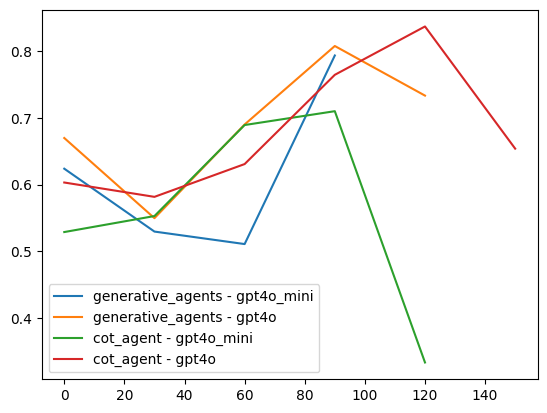

In [15]:
# Plot the performance of each arch - llm_model by bin
import matplotlib.pyplot as plt

for arch in summary:
    for llm_model in summary[arch]:
        plt.plot(list(summary[arch][llm_model].keys()), list(summary[arch][llm_model].values()), label=f'{arch} - {llm_model}')
plt.legend()

In [62]:
def avoid_taking_last_apple(trees_info, observations, action):
    OBS_WINDOW_SIZE = (11, 11)

    if re.match(r'go to', action, re.IGNORECASE):
        destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
        if destination:
            destination = tuple(map(int, destination.group(1).split(',')))
            destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                return None
            # If the destination is an apple
            elif trees_info['map'][destination[0], destination[1]] == 'A':
                trees_mask = list(map(lambda x: any(map(lambda el: el == list(destination), x['elements'])), trees_info['trees']))
                tree_id = trees_mask.index(True)

                tree = trees_info['trees_stats'][tree_id]
                apples = tree['apples']
                if apples == 1:
                    return False

    # Closest tree
    trees_distance_to_agent = list(map(lambda x: manhattan_distance(x['center'], observations['local_position']), trees_info['trees']))
    if len(trees_distance_to_agent) == 0:
        return None
    closest_tree = trees_distance_to_agent.index(min(trees_distance_to_agent))
    closest_tree_apples = trees_info['trees_stats'][closest_tree]['apples']
    if closest_tree_apples == 1:
        return True
    return None
            

In [63]:
def get_file_avoid_apple_score(file_data, type=None):
    avoided_last_apple = []
    for i in range(len(file_data['game_observations_for_act'])):
        did_avoid_last_apple = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=avoid_taking_last_apple)
        if did_avoid_last_apple is not None:
            avoided_last_apple.append(did_avoid_last_apple)
    
    times_avoided_last_apple = sum(avoided_last_apple)
    return times_avoided_last_apple / len(avoided_last_apple)
get_file_avoid_apple_score(accum_data)

0.4

In [64]:
results = evaluate_the_complete_scenario(folder, get_file_avoid_apple_score)

total prompts: 326 invalid_prompts: 1 act_prompts 70 70 act_responses: 70
total prompts: 483 invalid_prompts: 0 act_prompts 109 109 act_responses: 109
total prompts: 438 invalid_prompts: 0 act_prompts 106 106 act_responses: 106
total prompts: 339 invalid_prompts: 0 act_prompts 80 80 act_responses: 80
total prompts: 357 invalid_prompts: 0 act_prompts 78 78 act_responses: 78
total prompts: 264 invalid_prompts: 0 act_prompts 61 61 act_responses: 61
total prompts: 333 invalid_prompts: 0 act_prompts 71 71 act_responses: 71
total prompts: 484 invalid_prompts: 0 act_prompts 98 98 act_responses: 98
total prompts: 373 invalid_prompts: 0 act_prompts 79 79 act_responses: 79
total prompts: 722 invalid_prompts: 2 act_prompts 176 176 act_responses: 176
total prompts: 386 invalid_prompts: 13 act_prompts 77 77 act_responses: 77
total prompts: 428 invalid_prompts: 6 act_prompts 79 79 act_responses: 79
total prompts: 433 invalid_prompts: 7 act_prompts 91 91 act_responses: 91
total prompts: 350 invalid_p

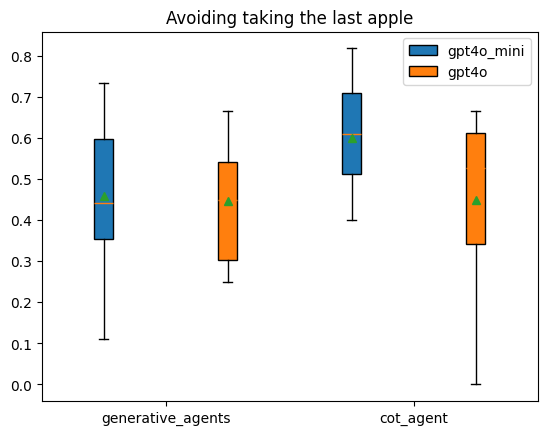

In [65]:
# Create a histogram for the average number of apples available when the agent decides to take an apple for each architecture and llm model
import matplotlib.pyplot as plt
import numpy as np

positions = np.arange(4)
for j, arch in enumerate(results):
    for i, llm_model in enumerate(results[arch]):
        # plt.bar(positions[j*2+i], np.mean(results[arch][llm_model]), label=f'{arch} - {llm_model}')
        # Color the bars depending on the llm model
        plt.boxplot(results[arch][llm_model], positions=[j*2+i], labels=[f'{arch} - {llm_model}'], patch_artist=True, boxprops=dict(facecolor=f'C{i}'), showmeans=True)
plt.xticks([0.5, 2.5], results.keys())
# Add custom legend just for the colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=f'C{i}', edgecolor='black', label=llm_model) for i, llm_model in enumerate(results[arch])]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Avoiding taking the last apple')
plt.show()

In [66]:
def go_to_empty_or_grass_reasonably(trees_info, observations, action):
    OBS_WINDOW_SIZE = (11, 11)

    if re.match(r'go to', action, re.IGNORECASE):
        destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
        if destination:
            destination = tuple(map(int, destination.group(1).split(',')))
            destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                return None

            # If the destination is grass or empty
            elif trees_info['map'][destination[0], destination[1]] == 'G' or trees_info['map'][destination[0], destination[1]] == 'F':
                # If only one tree
                if len(trees_info['trees_stats']) == 1:
                    apples_in_tree = trees_info['trees_stats'][0]['apples']
                    if apples_in_tree <= 4:
                        return True
                    else:
                        return False
                else:
                    apples_in_total = sum(map(lambda x: x['apples'], trees_info['trees_stats']))
                    if apples_in_total < 5:
                        return True
                    else:
                        return False
    return None

In [67]:
def get_file_go_to_empty_or_grass_reasonably(file_data, type=None):
    go_to_empty_with_reason = []
    for i in range(len(file_data['game_observations_for_act'])):
        action_score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=go_to_empty_or_grass_reasonably)
        if action_score is not None:
            go_to_empty_with_reason.append(action_score)
    
    times_scenario_seen = sum(go_to_empty_with_reason)
    return times_scenario_seen / len(go_to_empty_with_reason), len(go_to_empty_with_reason)
get_file_go_to_empty_or_grass_reasonably(accum_data)

(0.9333333333333333, 15)

In [68]:
results = evaluate_the_complete_scenario(folder, get_file_go_to_empty_or_grass_reasonably)
results

total prompts: 326 invalid_prompts: 1 act_prompts 70 70 act_responses: 70
total prompts: 483 invalid_prompts: 0 act_prompts 109 109 act_responses: 109
total prompts: 438 invalid_prompts: 0 act_prompts 106 106 act_responses: 106
total prompts: 339 invalid_prompts: 0 act_prompts 80 80 act_responses: 80
total prompts: 357 invalid_prompts: 0 act_prompts 78 78 act_responses: 78
total prompts: 264 invalid_prompts: 0 act_prompts 61 61 act_responses: 61
total prompts: 333 invalid_prompts: 0 act_prompts 71 71 act_responses: 71
total prompts: 484 invalid_prompts: 0 act_prompts 98 98 act_responses: 98
total prompts: 373 invalid_prompts: 0 act_prompts 79 79 act_responses: 79
total prompts: 722 invalid_prompts: 2 act_prompts 176 176 act_responses: 176
total prompts: 386 invalid_prompts: 13 act_prompts 77 77 act_responses: 77
total prompts: 428 invalid_prompts: 6 act_prompts 79 79 act_responses: 79
total prompts: 433 invalid_prompts: 7 act_prompts 91 91 act_responses: 91
total prompts: 350 invalid_p

{'generative_agents': {'gpt4o_mini': [(1.0, 10),
   (1.0, 16),
   (0.9090909090909091, 11),
   (0.9, 10),
   (0.8333333333333334, 6),
   (0.3333333333333333, 6),
   (0.8, 10),
   (0.7142857142857143, 14),
   (0.7272727272727273, 11),
   (0.918918918918919, 37)],
  'gpt4o': [(0.9333333333333333, 15),
   (0.9473684210526315, 19),
   (0.75, 8),
   (0.2, 5),
   (0.7727272727272727, 22),
   (0.5, 4),
   (0.9166666666666666, 12),
   (0.875, 8),
   (0.9090909090909091, 11),
   (0.8125, 16)]},
 'cot_agent': {'gpt4o_mini': [(0.42857142857142855, 7),
   (0.5, 6),
   (0.5, 8),
   (0.5833333333333334, 12),
   (0.4, 15),
   (0.5454545454545454, 11),
   (0.4166666666666667, 12),
   (0.5714285714285714, 14),
   (0.5294117647058824, 17),
   (0.5555555555555556, 9)],
  'gpt4o': [(0.8571428571428571, 7),
   (0.7, 10),
   (1.0, 5),
   (0.625, 8),
   (0.7142857142857143, 14),
   (0.0, 3),
   (0.75, 4),
   (0.875, 8),
   (0.5, 2),
   (0.8, 5)]}}

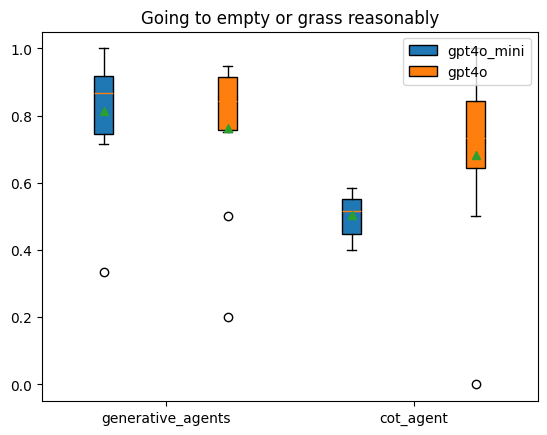

In [69]:
positions = np.arange(4)
for j, arch in enumerate(results):
    for i, llm_model in enumerate(results[arch]):
        # plt.bar(positions[j*2+i], np.mean(results[arch][llm_model]), label=f'{arch} - {llm_model}')
        # Color the bars depending on the llm model
        model_results = results[arch][llm_model]
        model_results = list(map(lambda x: x[0], model_results))
        plt.boxplot(model_results, positions=[j*2+i], labels=[f'{arch} - {llm_model}'], patch_artist=True, boxprops=dict(facecolor=f'C{i}'), showmeans=True)
plt.xticks([0.5, 2.5], results.keys())
# Add custom legend just for the colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=f'C{i}', edgecolor='black', label=llm_model) for i, llm_model in enumerate(results[arch])]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Going to empty or grass reasonably')
plt.show()

In [70]:
def take_apple_from_abundant_tree(trees_info, observations, action):
    OBS_WINDOW_SIZE = (11, 11)

    if re.match(r'go to', action, re.IGNORECASE):
        destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
        if destination:
            destination = tuple(map(int, destination.group(1).split(',')))
            destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                return None

            elif trees_info['map'][destination[0], destination[1]] == 'A':
                trees_mask = list(map(lambda x: any(map(lambda el: el == list(destination), x['elements'])), trees_info['trees']))
                tree_id = trees_mask.index(True)

                tree = trees_info['trees_stats'][tree_id]
                apples = tree['apples']
                if apples >= 4:
                    return True
                elif apples < 4:
                    return False
    return None

In [71]:
def get_file_take_apple_from_abundant_tree(file_data, type=None):
    go_to_empty_with_reason = []
    for i in range(len(file_data['game_observations_for_act'])):
        action_score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=take_apple_from_abundant_tree)
        if action_score is not None:
            go_to_empty_with_reason.append(action_score)
    
    times_scenario_seen = sum(go_to_empty_with_reason)
    return times_scenario_seen / len(go_to_empty_with_reason), len(go_to_empty_with_reason)
get_file_take_apple_from_abundant_tree(accum_data)

(0.5853658536585366, 41)

In [72]:
results = evaluate_the_complete_scenario(folder, get_file_take_apple_from_abundant_tree)
results

total prompts: 326 invalid_prompts: 1 act_prompts 70 70 act_responses: 70
total prompts: 483 invalid_prompts: 0 act_prompts 109 109 act_responses: 109
total prompts: 438 invalid_prompts: 0 act_prompts 106 106 act_responses: 106
total prompts: 339 invalid_prompts: 0 act_prompts 80 80 act_responses: 80
total prompts: 357 invalid_prompts: 0 act_prompts 78 78 act_responses: 78
total prompts: 264 invalid_prompts: 0 act_prompts 61 61 act_responses: 61
total prompts: 333 invalid_prompts: 0 act_prompts 71 71 act_responses: 71
total prompts: 484 invalid_prompts: 0 act_prompts 98 98 act_responses: 98
total prompts: 373 invalid_prompts: 0 act_prompts 79 79 act_responses: 79
total prompts: 722 invalid_prompts: 2 act_prompts 176 176 act_responses: 176
total prompts: 386 invalid_prompts: 13 act_prompts 77 77 act_responses: 77
total prompts: 428 invalid_prompts: 6 act_prompts 79 79 act_responses: 79
total prompts: 433 invalid_prompts: 7 act_prompts 91 91 act_responses: 91
total prompts: 350 invalid_p

{'generative_agents': {'gpt4o_mini': [(0.4772727272727273, 44),
   (0.4375, 64),
   (0.75, 72),
   (0.6829268292682927, 41),
   (0.6578947368421053, 38),
   (0.46808510638297873, 47),
   (0.5, 46),
   (0.5344827586206896, 58),
   (0.5283018867924528, 53),
   (0.5507246376811594, 69)],
  'gpt4o': [(0.5853658536585366, 41),
   (0.48717948717948717, 39),
   (0.5454545454545454, 55),
   (0.5, 36),
   (0.6097560975609756, 41),
   (0.5614035087719298, 57),
   (0.5789473684210527, 57),
   (0.5531914893617021, 47),
   (0.5, 28),
   (0.5116279069767442, 43)]},
 'cot_agent': {'gpt4o_mini': [(0.36363636363636365, 11),
   (0.6842105263157895, 19),
   (0.47058823529411764, 17),
   (0.5714285714285714, 14),
   (0.5263157894736842, 19),
   (0.6, 20),
   (0.43478260869565216, 23),
   (0.68, 25),
   (0.7058823529411765, 17),
   (0.4117647058823529, 17)],
  'gpt4o': [(0.5789473684210527, 19),
   (0.3333333333333333, 21),
   (0.45454545454545453, 11),
   (0.3333333333333333, 15),
   (0.14285714285714285,

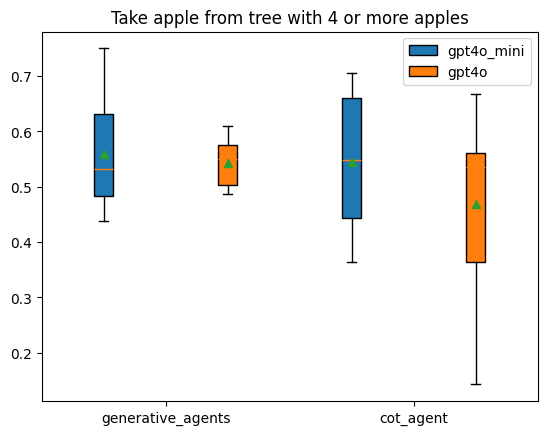

In [73]:
positions = np.arange(4)
for j, arch in enumerate(results):
    for i, llm_model in enumerate(results[arch]):
        # Color the bars depending on the llm model
        model_results = results[arch][llm_model]
        model_results = list(map(lambda x: x[0], model_results))
        plt.boxplot(model_results, positions=[j*2+i], labels=[f'{arch} - {llm_model}'], patch_artist=True, boxprops=dict(facecolor=f'C{i}'), showmeans=True)
plt.xticks([0.5, 2.5], results.keys())
# Add custom legend just for the colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=f'C{i}', edgecolor='black', label=llm_model) for i, llm_model in enumerate(results[arch])]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Take apple from tree with 4 or more apples')
plt.show()

In [75]:
def take_apple_from_tree_with_more_apples(trees_info, observations, action):
    OBS_WINDOW_SIZE = (11, 11)

    if re.match(r'go to', action, re.IGNORECASE):
        destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
        if destination:
            destination = tuple(map(int, destination.group(1).split(',')))
            destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                return None
            
            if trees_info['map'][destination[0], destination[1]] != 'A':
                return None
            
            # If there is another agent
            if len(observations['agents_in_observation'].values()) > 0:
                trees_mask = list(map(lambda x: any(map(lambda el: el == list(destination), x['elements'])), trees_info['trees']))
                tree_id = trees_mask.index(True)

                tree_with_more_apples = max(trees_info['trees_stats'], key=lambda x: x['apples'])
                tree_with_more_apples_id = trees_info['trees_stats'].index(tree_with_more_apples)

                if tree_with_more_apples_id == tree_id:
                    return True
                else:
                    return False
                    
    return None

In [76]:
def get_file_take_apple_from_tree_with_more_apples(file_data, type=None):
    go_to_empty_with_reason = []
    for i in range(len(file_data['game_observations_for_act'])):
        action_score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=take_apple_from_tree_with_more_apples)
        if action_score is not None:
            go_to_empty_with_reason.append(action_score)
    
    times_scenario_seen = sum(go_to_empty_with_reason)
    if not len(go_to_empty_with_reason):
        return None, 0
    return times_scenario_seen / len(go_to_empty_with_reason), len(go_to_empty_with_reason)
get_file_take_apple_from_tree_with_more_apples(accum_data)

(0.7916666666666666, 24)

In [78]:
results = evaluate_the_complete_scenario(folder, get_file_take_apple_from_tree_with_more_apples)
results

total prompts: 326 invalid_prompts: 1 act_prompts 70 70 act_responses: 70
total prompts: 483 invalid_prompts: 0 act_prompts 109 109 act_responses: 109
total prompts: 438 invalid_prompts: 0 act_prompts 106 106 act_responses: 106
total prompts: 339 invalid_prompts: 0 act_prompts 80 80 act_responses: 80
total prompts: 357 invalid_prompts: 0 act_prompts 78 78 act_responses: 78
total prompts: 264 invalid_prompts: 0 act_prompts 61 61 act_responses: 61
total prompts: 333 invalid_prompts: 0 act_prompts 71 71 act_responses: 71
total prompts: 484 invalid_prompts: 0 act_prompts 98 98 act_responses: 98
total prompts: 373 invalid_prompts: 0 act_prompts 79 79 act_responses: 79
total prompts: 722 invalid_prompts: 2 act_prompts 176 176 act_responses: 176
total prompts: 386 invalid_prompts: 13 act_prompts 77 77 act_responses: 77
total prompts: 428 invalid_prompts: 6 act_prompts 79 79 act_responses: 79
total prompts: 433 invalid_prompts: 7 act_prompts 91 91 act_responses: 91
total prompts: 350 invalid_p

{'generative_agents': {'gpt4o_mini': [(0.6, 25),
   (0.7619047619047619, 42),
   (0.78, 50),
   (0.5, 26),
   (0.5714285714285714, 21),
   (0.32, 25),
   (0.7916666666666666, 24),
   (0.6666666666666666, 30),
   (0.7, 20),
   (0.5652173913043478, 46)],
  'gpt4o': [(0.7916666666666666, 24),
   (0.6785714285714286, 28),
   (0.7692307692307693, 26),
   (0.7391304347826086, 23),
   (0.7142857142857143, 21),
   (0.6153846153846154, 39),
   (0.7631578947368421, 38),
   (0.59375, 32),
   (0.6, 20),
   (0.7083333333333334, 24)]},
 'cot_agent': {'gpt4o_mini': [(0.8, 5),
   (0.5555555555555556, 9),
   (1.0, 9),
   (0.7777777777777778, 9),
   (0.9166666666666666, 12),
   (0.8947368421052632, 19),
   (0.7857142857142857, 14),
   (0.9090909090909091, 11),
   (0.9166666666666666, 12),
   (0.7, 10)],
  'gpt4o': [(0.875, 8),
   (0.6428571428571429, 14),
   (1.0, 5),
   (0.8333333333333334, 12),
   (0.7272727272727273, 11),
   (0.6470588235294118, 17),
   (0.9090909090909091, 11),
   (0.636363636363636

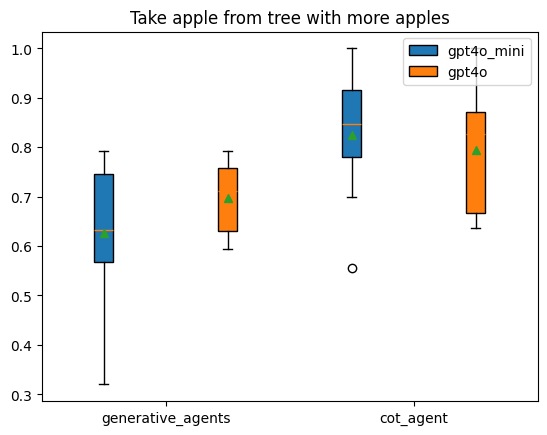

In [79]:
positions = np.arange(4)
for j, arch in enumerate(results):
    for i, llm_model in enumerate(results[arch]):
        # Color the bars depending on the llm model
        model_results = results[arch][llm_model]
        model_results = list(map(lambda x: x[0], model_results))
        plt.boxplot(model_results, positions=[j*2+i], labels=[f'{arch} - {llm_model}'], patch_artist=True, boxprops=dict(facecolor=f'C{i}'), showmeans=True)
plt.xticks([0.5, 2.5], results.keys())
# Add custom legend just for the colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=f'C{i}', edgecolor='black', label=llm_model) for i, llm_model in enumerate(results[arch])]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Take apple from tree with more apples')
plt.show()

In [80]:
def take_apple_when_few_tree(trees_info, observations, action):
    OBS_WINDOW_SIZE = (11, 11)

    all_observed_apples = sum(map(lambda x: x['apples'], trees_info['trees_stats']))
    if all_observed_apples > 4:
        return None

    if re.match(r'go to', action, re.IGNORECASE):
        destination = re.search(r'go to\s+position\s+[\(\[](\s*\d+\s*,\s*\d+\s*)[\]\)]', action, re.IGNORECASE)
        if destination:
            destination = tuple(map(int, destination.group(1).split(',')))
            destination = get_local_position_from_global(observations['orientation'], destination, observations['global_position'], observations['local_position'])
            # If the destintation is out of the observation window
            if destination[0] < 0 or destination[0] >= OBS_WINDOW_SIZE[0] or destination[1] < 0 or destination[1] >= OBS_WINDOW_SIZE[1]:
                return False
            elif trees_info['map'][destination[0], destination[1]] == 'A':
                return True
    return False

In [81]:
def get_file_take_apple_when_few_tree(file_data, type=None):
    go_to_empty_with_reason = []
    for i in range(len(file_data['game_observations_for_act'])):
        action_score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=take_apple_when_few_tree)
        if action_score is not None:
            go_to_empty_with_reason.append(action_score)
    
    times_scenario_seen = sum(go_to_empty_with_reason)
    if not len(go_to_empty_with_reason):
        return None, 0
    return times_scenario_seen / len(go_to_empty_with_reason), len(go_to_empty_with_reason)
get_file_take_apple_when_few_tree(accum_data)

(0.32653061224489793, 49)

In [82]:
results = evaluate_the_complete_scenario(folder, get_file_take_apple_when_few_tree)

total prompts: 326 invalid_prompts: 1 act_prompts 70 70 act_responses: 70
total prompts: 483 invalid_prompts: 0 act_prompts 109 109 act_responses: 109
total prompts: 438 invalid_prompts: 0 act_prompts 106 106 act_responses: 106
total prompts: 339 invalid_prompts: 0 act_prompts 80 80 act_responses: 80
total prompts: 357 invalid_prompts: 0 act_prompts 78 78 act_responses: 78
total prompts: 264 invalid_prompts: 0 act_prompts 61 61 act_responses: 61
total prompts: 333 invalid_prompts: 0 act_prompts 71 71 act_responses: 71
total prompts: 484 invalid_prompts: 0 act_prompts 98 98 act_responses: 98
total prompts: 373 invalid_prompts: 0 act_prompts 79 79 act_responses: 79
total prompts: 722 invalid_prompts: 2 act_prompts 176 176 act_responses: 176
total prompts: 386 invalid_prompts: 13 act_prompts 77 77 act_responses: 77
total prompts: 428 invalid_prompts: 6 act_prompts 79 79 act_responses: 79
total prompts: 433 invalid_prompts: 7 act_prompts 91 91 act_responses: 91
total prompts: 350 invalid_p

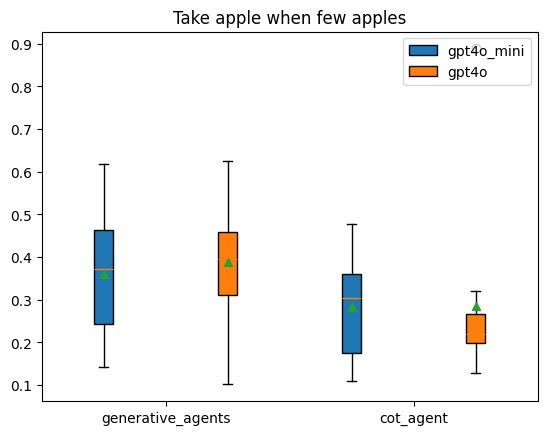

In [83]:
positions = np.arange(4)
for j, arch in enumerate(results):
    for i, llm_model in enumerate(results[arch]):
        # Color the bars depending on the llm model
        model_results = results[arch][llm_model]
        model_results = list(map(lambda x: x[0], model_results))
        plt.boxplot(model_results, positions=[j*2+i], labels=[f'{arch} - {llm_model}'], patch_artist=True, boxprops=dict(facecolor=f'C{i}'), showmeans=True)
plt.xticks([0.5, 2.5], results.keys())
# Add custom legend just for the colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=f'C{i}', edgecolor='black', label=llm_model) for i, llm_model in enumerate(results[arch])]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Take apple when few apples')
plt.show()

In [84]:
def explore_when_enough_apples(trees_info, observations, action):
    all_observed_apples = sum(map(lambda x: x['apples'], trees_info['trees_stats']))
    if all_observed_apples <= 4:
        return None

    if re.match(r'explore', action, re.IGNORECASE):
        return True
    return False

In [85]:
def get_file_explore_when_enough_apples(file_data, type=None):
    go_to_empty_with_reason = []
    for i in range(len(file_data['game_observations_for_act'])):
        action_score = eval_action(file_data['game_observations_for_act'][i], file_data['act_prompts_response'][i], type=arch, score_action_fn=explore_when_enough_apples)
        if action_score is not None:
            go_to_empty_with_reason.append(action_score)
    
    times_scenario_seen = sum(go_to_empty_with_reason)
    if not len(go_to_empty_with_reason):
        return None, 0
    return times_scenario_seen / len(go_to_empty_with_reason), len(go_to_empty_with_reason)
get_file_explore_when_enough_apples(accum_data)

(0.07142857142857142, 28)

In [86]:
results = evaluate_the_complete_scenario(folder, get_file_explore_when_enough_apples)

total prompts: 326 invalid_prompts: 1 act_prompts 70 70 act_responses: 70
total prompts: 483 invalid_prompts: 0 act_prompts 109 109 act_responses: 109
total prompts: 438 invalid_prompts: 0 act_prompts 106 106 act_responses: 106
total prompts: 339 invalid_prompts: 0 act_prompts 80 80 act_responses: 80
total prompts: 357 invalid_prompts: 0 act_prompts 78 78 act_responses: 78
total prompts: 264 invalid_prompts: 0 act_prompts 61 61 act_responses: 61
total prompts: 333 invalid_prompts: 0 act_prompts 71 71 act_responses: 71
total prompts: 484 invalid_prompts: 0 act_prompts 98 98 act_responses: 98
total prompts: 373 invalid_prompts: 0 act_prompts 79 79 act_responses: 79
total prompts: 722 invalid_prompts: 2 act_prompts 176 176 act_responses: 176
total prompts: 386 invalid_prompts: 13 act_prompts 77 77 act_responses: 77
total prompts: 428 invalid_prompts: 6 act_prompts 79 79 act_responses: 79
total prompts: 433 invalid_prompts: 7 act_prompts 91 91 act_responses: 91
total prompts: 350 invalid_p

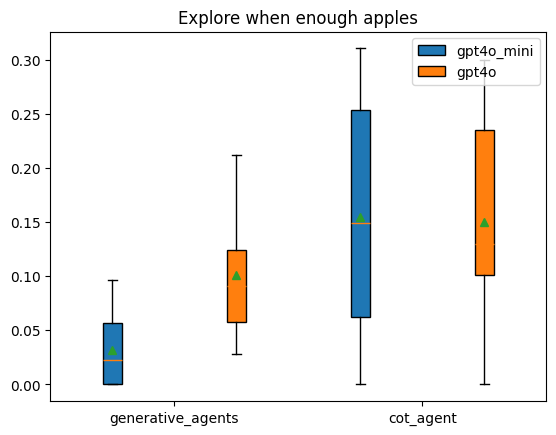

In [87]:
positions = np.arange(4)
for j, arch in enumerate(results):
    for i, llm_model in enumerate(results[arch]):
        # Color the bars depending on the llm model
        model_results = results[arch][llm_model]
        model_results = list(map(lambda x: x[0], model_results))
        plt.boxplot(model_results, positions=[j*2+i], labels=[f'{arch} - {llm_model}'], patch_artist=True, boxprops=dict(facecolor=f'C{i}'), showmeans=True)
plt.xticks([0.5, 2.5], results.keys())
# Add custom legend just for the colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Patch(facecolor=f'C{i}', edgecolor='black', label=llm_model) for i, llm_model in enumerate(results[arch])]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Explore when enough apples')
plt.show()